# Generalised Empirical Interpolation Method: hyperparameter tuning
This notebook takes the magic functions/sensors and tunes the hyperparameter $\lambda$ for the Tikhonov regularisation of the Generalised Empirical Interpolation Method (TR-GEIM).

Let us create the mesh from the OpenFOAM nodes and cells

In [85]:
from pyforce.tools.write_read import ReadFromOF
from utils import create_mesh_dolfinx
from IPython.display import clear_output as clc

path_snaps = '../../../Data/MSFR/'
domain, ct, ft, gdim = create_mesh_dolfinx(path_snaps+'EVOL_geom_noreflector.geo')

Info    : Reading '../../../Data/MSFR/EVOL_geom_noreflector.geo'...
Info    : Done reading '../../../Data/MSFR/EVOL_geom_noreflector.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 50%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 60%] Meshing curve 13 (Line)
Info    : [ 60%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 70%] Meshing curve 16 (Line)
Info    : [ 70%] Meshing curve 17 (Line)
Info    : [ 80%] Meshing curve 18 (Line)
Info    : [ 80%] Meshing curve 19 (Line)
Info    : [ 80%] Meshing curve 20 (Line)
Info    : [ 90%] Meshing cu

Let us import the snapshots, variable names and time

In [86]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('Results/times.npz')['fom_times']

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, VectorElement("Lagrange", domain.ufl_cell(), 1)),
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1))
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train, test and predict
\begin{equation}
    \left\{
        \begin{aligned}
            \Xi_{\text{train}} &= [0:0.025:20] \setminus[0.1:0.1:20] \\
            \Xi_{\text{test}} &= [0.1:0.1:20]\\
            \Xi_{\text{predict}} &= [20:0.025:25]\\
        \end{aligned}
    \right.
\end{equation}
such that $\Xi_{\text{train}}\cap \Xi_{\text{test}}=\emptyset$.

In [87]:
Nt = len(fom_times)
cut_train = int(0.8*Nt)

measured_field_i = 0

train_indices = np.arange(0, cut_train)
test_indices = train_indices[3::4]
train_indices = np.delete(train_indices, test_indices)
predict_indices = np.arange(cut_train, Nt)

valid_indices = test_indices[::2]

valid_snaps = FunctionsList(fun_spaces[measured_field_i])
for ii in valid_indices:
    valid_snaps.append(snaps[var_names[measured_field_i]](ii))

test_snaps = FunctionsList(fun_spaces[measured_field_i])
for ii in test_indices:
    test_snaps.append(snaps[var_names[measured_field_i]](ii))

predict_snaps = FunctionsList(fun_spaces[measured_field_i])
for ii in predict_indices:
    predict_snaps.append(snaps[var_names[measured_field_i]](ii))

Let us import the magic functions/sensors


In [88]:
from pyforce.tools.write_read import ImportH5

path_offline = 'Results/GEIM_offline/'
strategies = ['ID', 'BF', 'BP']

magic_functions = {strategy: ImportH5(fun_spaces[measured_field_i],
                          path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_mf',
                          f'GEIM_{var_names[measured_field_i]}_{strategy}_mf')[0]
                for strategy in strategies}
magic_sensors = {strategy: ImportH5(fun_spaces[measured_field_i],
                          path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_ms',
                          f'GEIM_{var_names[measured_field_i]}_{strategy}_ms')[0]
                for strategy in strategies}

training_betas = {strategy: np.load(path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_TrainBeta.npz')['arr_0']
                  for strategy in strategies}

mean_beta = {strategy: np.mean(training_betas[strategy], axis=0)
                for strategy in strategies}
std_beta = {strategy: np.std(training_betas[strategy], axis=0)
                for strategy in strategies}

## Tuning the regularisation parameter $\lambda$

The TR-GEIM is a regularised version of the GEIM. The regularisation parameter $\lambda$ is used to control the interpolation when the data is noisy.

In [89]:
from pyforce.online.tr_geim import TRGEIM

trgeim = {strategy: TRGEIM(magic_functions[strategy],
                           magic_sensors[strategy],
                           mean_beta=mean_beta[strategy],
                           std_beta=std_beta[strategy], name = var_names[measured_field_i])
            for strategy in strategies}

Mmax = 25
noise_value = 2.3

res_opt = dict()
for strategy in strategies:
    res_opt[strategy] = trgeim[strategy].hyperparameter_tuning(valid_snaps, noise_value=noise_value, 
                                   lambda_lim=[1,200], n_samples=50, M = Mmax,
                                   num_repeats=10,
                                   verbose=True)

TR-GEIM HyperParameter Tuning for sigma = 2.30 - T: 50.000 / 50.00 - 0.442 s/it
TR-GEIM HyperParameter Tuning for sigma = 2.30 - T: 50.000 / 50.00 - 0.446 s/it
TR-GEIM HyperParameter Tuning for sigma = 2.30 - T: 50.000 / 50.00 - 0.441 s/it


Let us plot the error of the TR-GEIM for different values of $\lambda$.

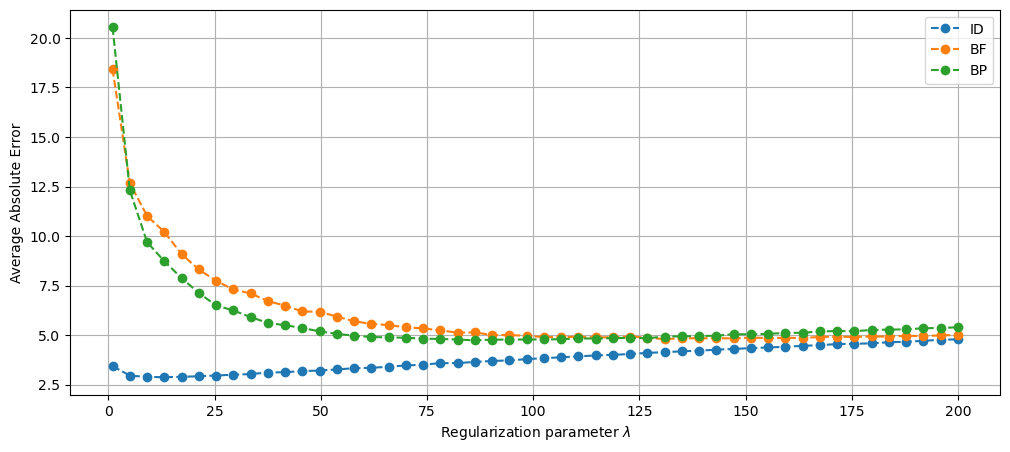

In [90]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 5))

for strategy in strategies:
    plt.plot(res_opt[strategy][1], res_opt[strategy][2], 'o--', label=strategy)

plt.legend()
plt.xlabel('Regularization parameter $\lambda$')
plt.ylabel('Average Absolute Error')
plt.grid()

The optimal values for $\lambda$ are:
- ID: $\sigma^2=2.3^2$
- BF: 75
- BP: 75

In [91]:
reg_params = {'ID': noise_value**2,
              'BF': 75,
              'BP': 75}

## Online Phase
The online phase of the TR-GEIM is performed

### Interpolation regime
Let us now perform the online phase of TR-GEIM in interpolation regime

In [ ]:
online_test_results = dict()

for strategy in strategies:
    print(f'Online testing for {strategy} strategy')
    _res = trgeim[strategy].synt_test_error(    test_snaps, 
                                                noise_value=noise_value, reg_param=reg_params[strategy], 
                                                M=25, verbose=False)

    online_test_results[strategy] = {
        'abs_err': _res[0],
        'rel_err': _res[1],
        'compt_time': _res[2]
    }


Online testing for ID strategy
Online testing for BF strategy
Online testing for BP strategy


Let us plot the absolute and relative error of the TR-GEIM reconstruction for the different strategies.

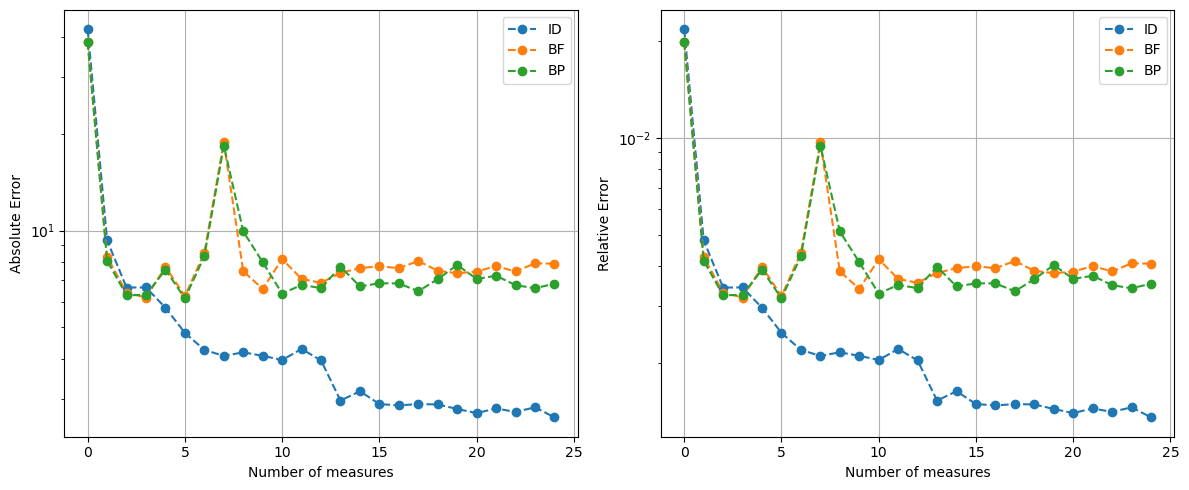

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for strategy in strategies:
    axs[0].plot(online_test_results[strategy]['abs_err'], 'o--', label=strategy)
    axs[1].plot(online_test_results[strategy]['rel_err'], 'o--', label=strategy)

for ax in axs:
    ax.grid()
    ax.set_xlabel('Number of measures')
    ax.set_yscale('log')
    ax.legend()

axs[0].set_ylabel('Absolute Error')
axs[1].set_ylabel('Relative Error')

plt.tight_layout()

Let us compare the computational time of the TR-GEIM estimation.

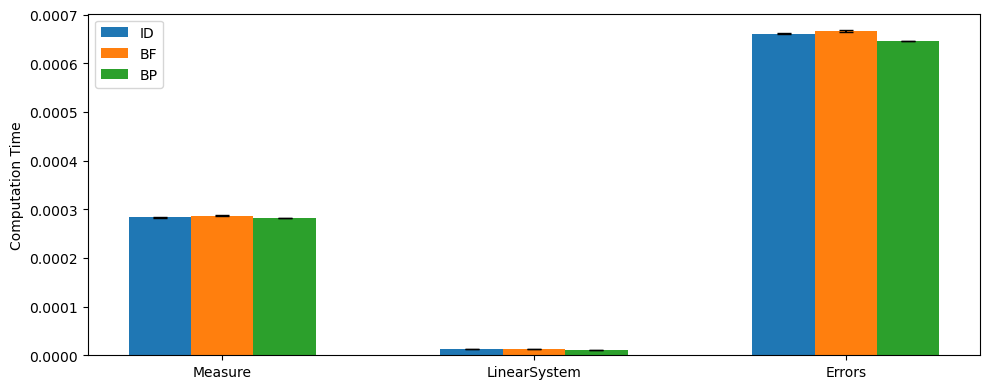

In [99]:
keys = ['Measure', 'LinearSystem', 'Errors']
strategies = list(online_test_results.keys())

# Prepare data
means = []
errors = []

for key in keys:
    key_means = []
    key_errors = []
    for strategy in strategies:
        data = np.array(online_test_results[strategy]['compt_time'][key])  
        mean_value = data.mean()
        std_err = data.std(ddof=1) / np.sqrt(data.size) 
        key_means.append(mean_value)
        key_errors.append(std_err)
    means.append(key_means)
    errors.append(key_errors)

means = np.array(means).T  
errors = np.array(errors).T

# Plot
x = np.arange(len(keys))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 4))
for i, strategy in enumerate(strategies):
    ax.bar(x + i*width, means[i], width, yerr=errors[i], label=strategy, capsize=5)

ax.set_xticks(x + width * (len(strategies)-1)/2)
ax.set_xticklabels(keys)
ax.set_ylabel('Computation Time')
ax.legend()

plt.tight_layout()

Let us make some contour plots of the TR-GEIM reconstruction for the different strategies.

At first, the reconstruction is generated.

In [100]:
recons = {
    strategy: np.array([trgeim[strategy].reconstruct(snap, M=Mmax, noise_value=noise_value, reg_param=reg_params[strategy])[0]
                        for snap in test_snaps._list])
    for strategy in strategies
}

Then, the contour plots are generated.

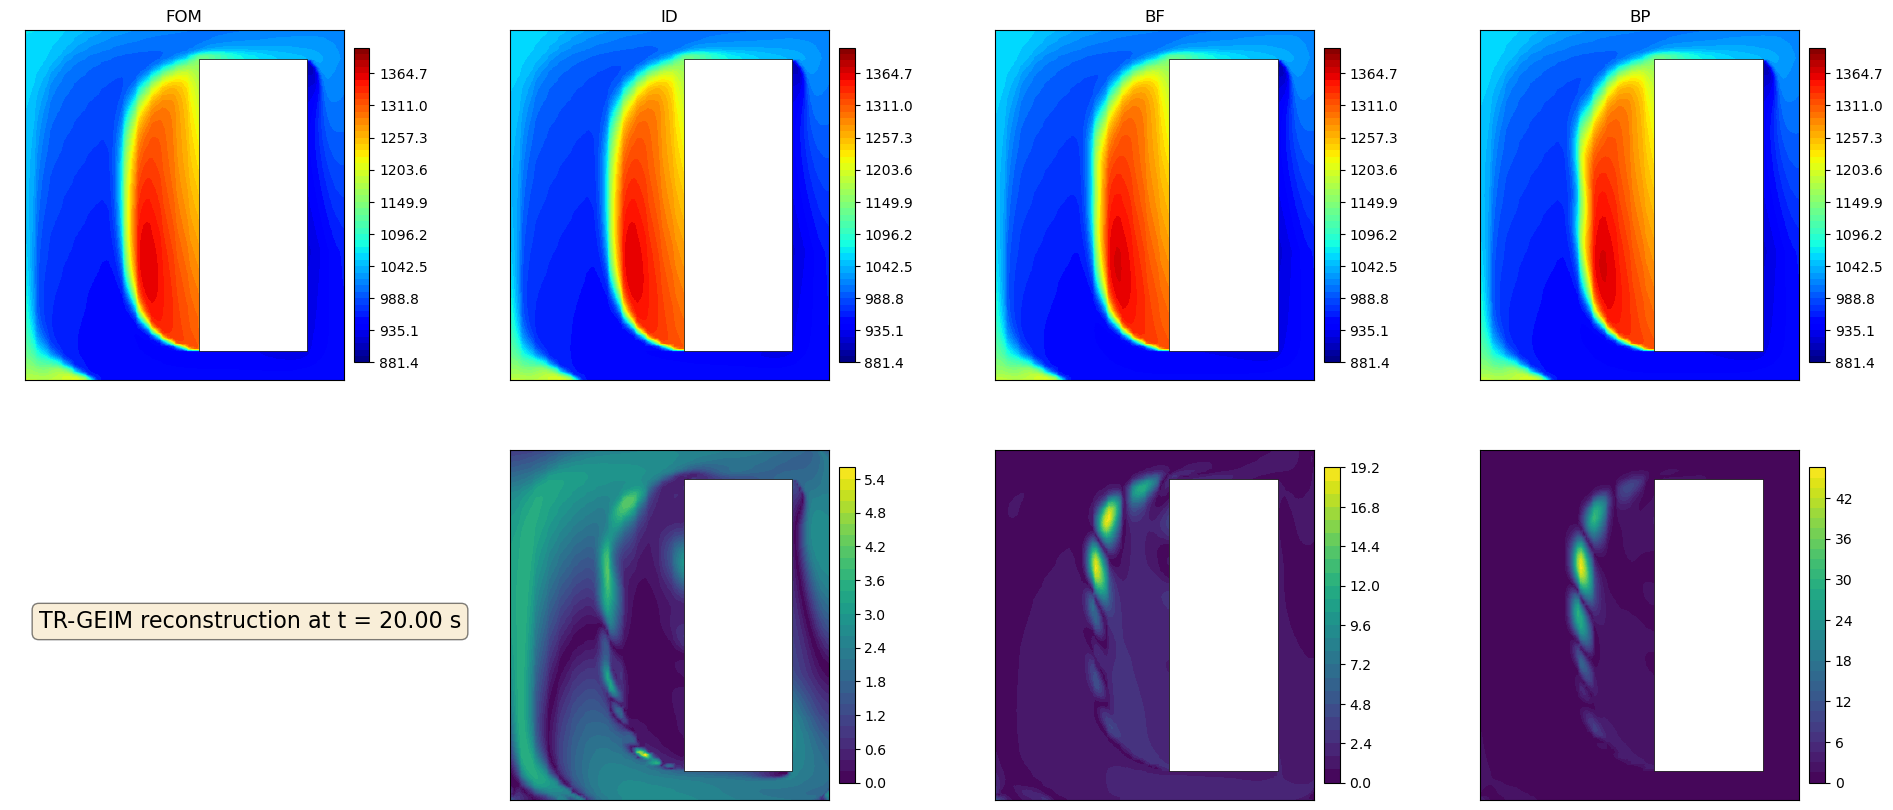

In [101]:
from matplotlib import cm
from utils import plot_contour

levels = np.linspace(test_snaps.return_matrix().min(), test_snaps.return_matrix().max(), 50)

sampling = 10
for tt in range(sampling-1, len(test_snaps), 10):

    fig, axs = plt.subplots(2, len(strategies)+1, figsize=((len(strategies)+1)*6, 10))

    cont = plot_contour(axs[0,0], domain.geometry.x[:, :2], test_snaps(tt), levels=levels)
    fig.colorbar(cont, ax=axs[0,0], pad=0.025, shrink=0.9)
    axs[0,0].set_title('FOM')
    axs[1,0].axis('off')

    for i, strategy in enumerate(strategies):
        cont = plot_contour(axs[0,i+1], domain.geometry.x[:, :2], recons[strategy][tt], levels=levels)
        fig.colorbar(cont, ax=axs[0,i+1], pad=0.025, shrink=0.9)
        axs[0,i+1].set_title(strategy)

        res_cont = plot_contour(axs[1,i+1], domain.geometry.x[:, :2], np.abs(recons[strategy][tt] - test_snaps(tt)), levels=30, cmap=cm.viridis)
        fig.colorbar(res_cont, ax=axs[1,i+1], pad=0.025, shrink=0.9)

    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="wheat", alpha=0.5)
    fig.text(0.225, 0.3, f'TR-GEIM reconstruction at t = {fom_times[test_indices[tt]]:.2f} s', 
             ha='center', va='top', fontsize=16, bbox=bbox_props)

    plt.show()
    clc(wait=True)
    plt.close(fig)

Let us plot the maximum value of the TR-GEIM reconstruction for the different strategies.

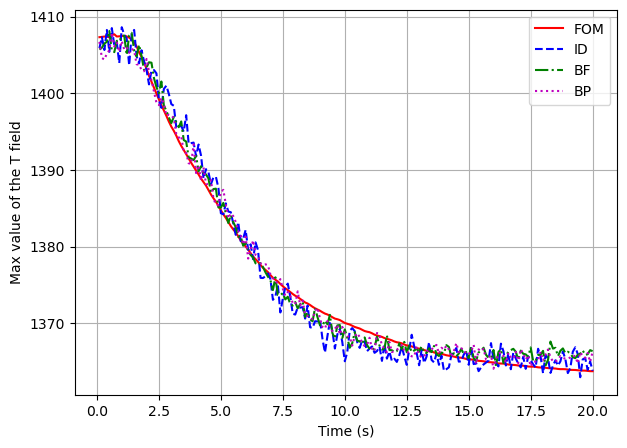

In [110]:
fig = plt.figure(figsize=(7, 5))

plt.plot(fom_times[test_indices], test_snaps.return_matrix().max(axis=0), 'r-', label='FOM')

colors = ['b', 'g', 'm']
linestyles = ['--', '-.', ':']
for i, strategy in enumerate(strategies):
    plt.plot(fom_times[test_indices], recons[strategy].max(axis=1), color=colors[i], linestyle=linestyles[i], label=strategy)

plt.xlabel('Time (s)')
plt.ylabel(f'Max value of the {var_names[measured_field_i]} field')
plt.grid()
plt.legend()

### Prediction regime
Let us now perform the online phase of TR-GEIM in prediction regime

In [113]:
online_pred_results = dict()

for strategy in strategies:
    print(f'Online prediction for {strategy} strategy')
    _res = trgeim[strategy].synt_test_error(    predict_snaps, 
                                                noise_value=noise_value, reg_param=reg_params[strategy], 
                                                M=25, verbose=False)

    online_pred_results[strategy] = {
        'abs_err': _res[0],
        'rel_err': _res[1],
        'compt_time': _res[2]
    }


Online prediction for ID strategy
Online prediction for BF strategy
Online prediction for BP strategy


Let us plot the absolute and relative error of the TR-GEIM reconstruction for the different strategies.

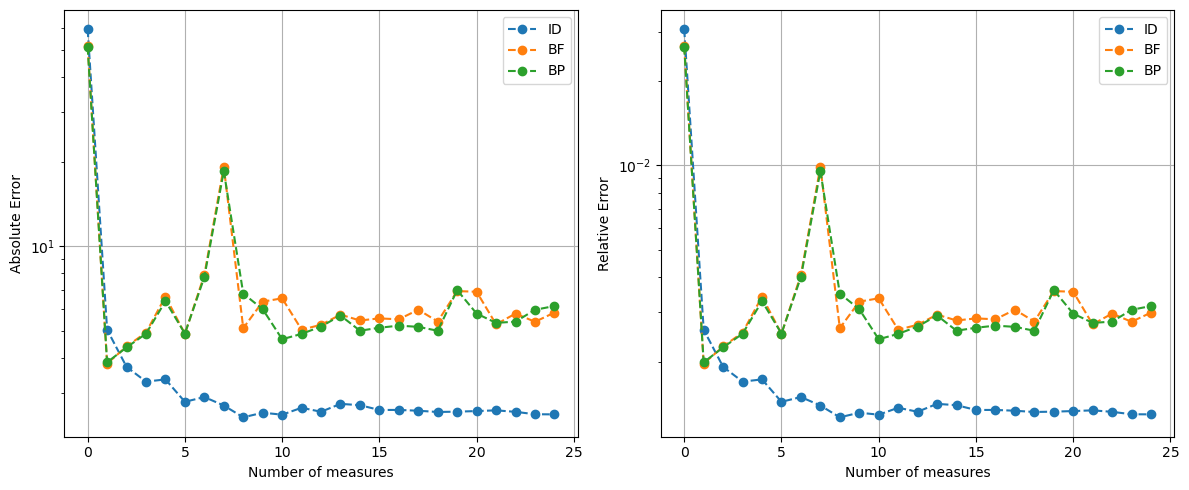

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for strategy in strategies:
    axs[0].plot(online_pred_results[strategy]['abs_err'], 'o--', label=strategy)
    axs[1].plot(online_pred_results[strategy]['rel_err'], 'o--', label=strategy)

for ax in axs:
    ax.grid()
    ax.set_xlabel('Number of measures')
    ax.set_yscale('log')
    ax.legend()

axs[0].set_ylabel('Absolute Error')
axs[1].set_ylabel('Relative Error')

plt.tight_layout()

Let us compare the computational time of the TR-GEIM estimation.

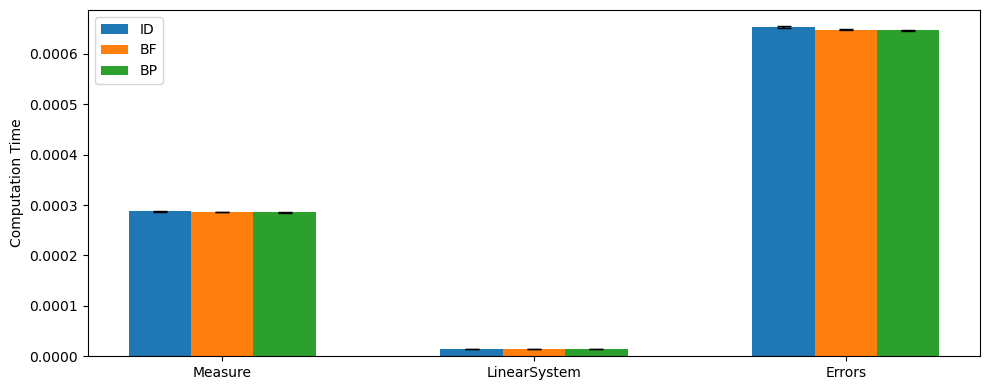

In [115]:
keys = ['Measure', 'LinearSystem', 'Errors']
strategies = list(online_pred_results.keys())

# Prepare data
means = []
errors = []

for key in keys:
    key_means = []
    key_errors = []
    for strategy in strategies:
        data = np.array(online_pred_results[strategy]['compt_time'][key])  
        mean_value = data.mean()
        std_err = data.std(ddof=1) / np.sqrt(data.size) 
        key_means.append(mean_value)
        key_errors.append(std_err)
    means.append(key_means)
    errors.append(key_errors)

means = np.array(means).T  
errors = np.array(errors).T

# Plot
x = np.arange(len(keys))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 4))
for i, strategy in enumerate(strategies):
    ax.bar(x + i*width, means[i], width, yerr=errors[i], label=strategy, capsize=5)

ax.set_xticks(x + width * (len(strategies)-1)/2)
ax.set_xticklabels(keys)
ax.set_ylabel('Computation Time')
ax.legend()

plt.tight_layout()

Let us make some contour plots of the TR-GEIM reconstruction for the different strategies.

At first, the reconstruction is generated.

In [120]:
recons = {
    strategy: np.array([trgeim[strategy].reconstruct(snap, M=Mmax, noise_value=noise_value, reg_param=reg_params[strategy])[0]
                        for snap in predict_snaps._list])
    for strategy in strategies
}

Then, the contour plots are generated.

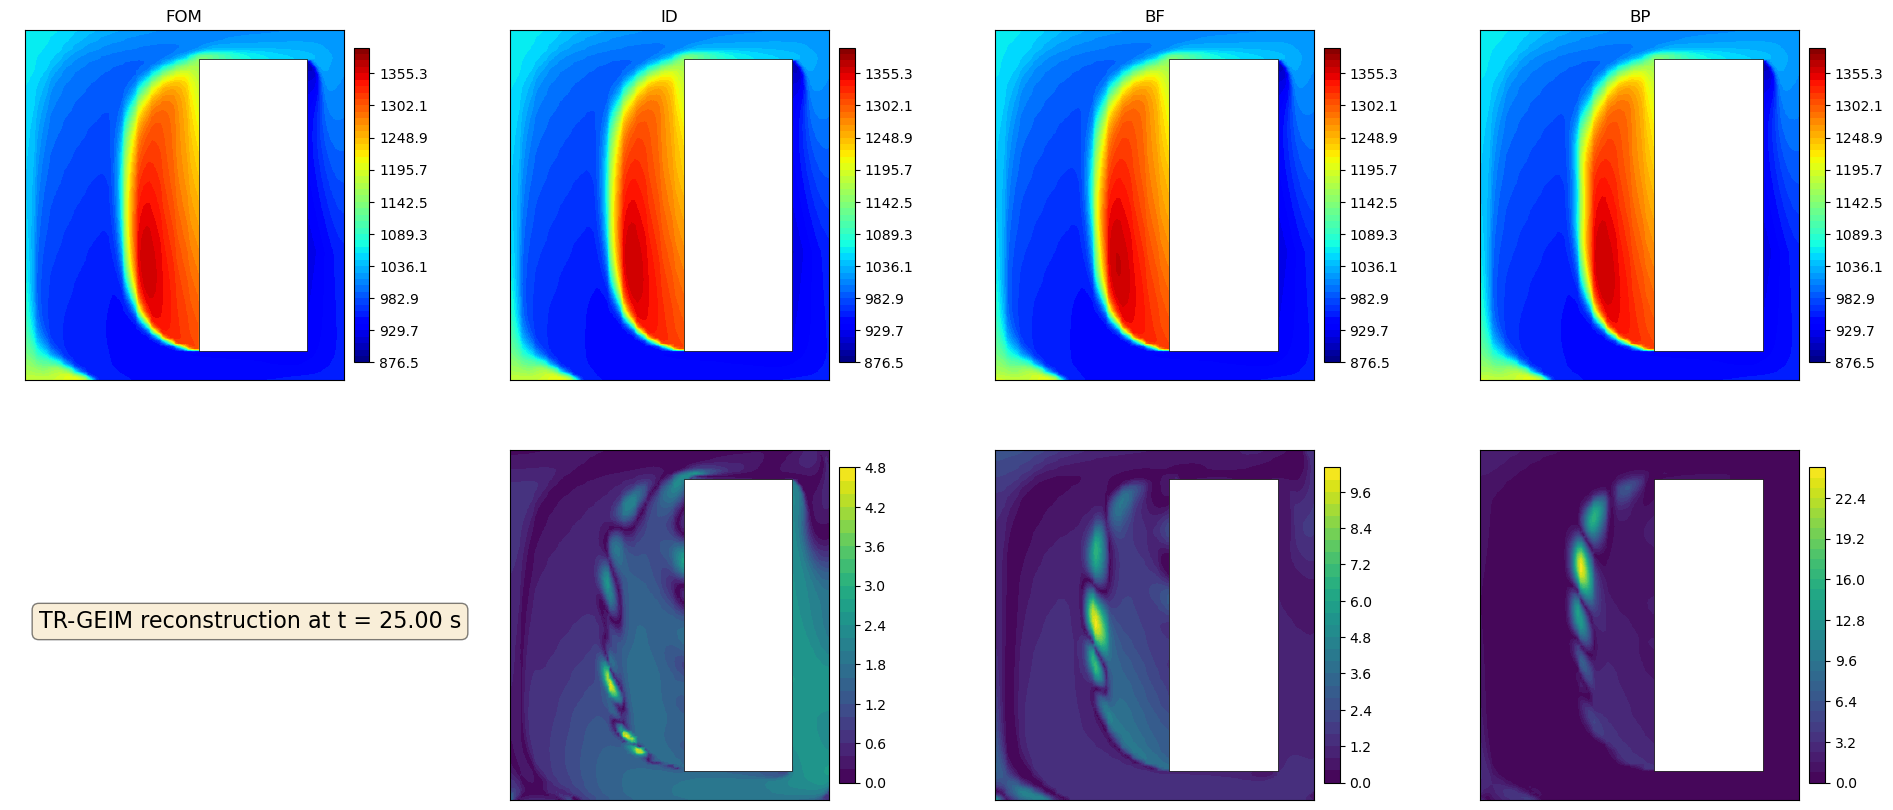

In [121]:
from matplotlib import cm
from utils import plot_contour

levels = np.linspace(predict_snaps.return_matrix().min()*0.975, predict_snaps.return_matrix().max()*1.025, 50)

sampling = 10
for tt in range(sampling-1, len(predict_snaps), 10):

    fig, axs = plt.subplots(2, len(strategies)+1, figsize=((len(strategies)+1)*6, 10))

    cont = plot_contour(axs[0,0], domain.geometry.x[:, :2], predict_snaps(tt), levels=levels)
    fig.colorbar(cont, ax=axs[0,0], pad=0.025, shrink=0.9)
    axs[0,0].set_title('FOM')
    axs[1,0].axis('off')

    for i, strategy in enumerate(strategies):
        cont = plot_contour(axs[0,i+1], domain.geometry.x[:, :2], recons[strategy][tt], levels=levels)
        fig.colorbar(cont, ax=axs[0,i+1], pad=0.025, shrink=0.9)
        axs[0,i+1].set_title(strategy)

        res_cont = plot_contour(axs[1,i+1], domain.geometry.x[:, :2], np.abs(recons[strategy][tt] - predict_snaps(tt)), levels=30, cmap=cm.viridis)
        fig.colorbar(res_cont, ax=axs[1,i+1], pad=0.025, shrink=0.9)

    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="wheat", alpha=0.5)
    fig.text(0.225, 0.3, f'TR-GEIM reconstruction at t = {fom_times[predict_indices[tt]]:.2f} s', 
             ha='center', va='top', fontsize=16, bbox=bbox_props)

    plt.show()
    clc(wait=True)
    plt.close(fig)